# SUMMARY

This notebook reproduces our best submission that scores **0.9016** on the private LB and reaches the **14th place**. The notebook implements a stacking ensemble of 35 CNN and ViT models (yes, they all fit into the 9-hour inference limit!). The training pipeline for the base models will be covered in a separate notebook.

![cassava](https://i.postimg.cc/d1dcZ6Zv/cassava.png)

You can read a detailed summary of our solution [in this discussion topic](https://www.kaggle.com/c/cassava-leaf-disease-classification/discussion/220751).

# PARAMETERS

In [1]:
####### NOTEBOOK CONFIGURATION

class CFG:
    
    # environment
    environment = 'kaggle'  # environment (kaggle, colab)
    device      = 'GPU'     # device (CPU, GPU, TPU)
    num_workers = 2         # no. cores
    debug       = False     # debug runs inference on a subset of training images
    
    # randomness
    seed = 13353  # random state

    # inference
    batch_size = 25  # no. images per batch
    num_tta    = 4   # no. TTA flips (between 1 and 8)
    one_fold   = 2   # use specific fold for all models
   
    # stacking parameters
    lgb_folds       = 5    # no. folds for stacking
    lgb_stop_rounds = 200  # no. early stopping rounds
    lgb_params      = {'objective':         'multiclass',
                       'metrics':           'multi_error',
                       'n_estimators':      10000,
                       'learning_rate':     0.01,
                       'num_leaves':        10,
                       'max_depth':         5,
                       'min_child_samples': 20,
                       'subsample':         0.3,
                       'colsample_bytree':  0.3,
                       'reg_alpha':         0.15,
                       'reg_lambda':        0.15,
                       'silent':            True,
                       'verbosity':         -1,
                       'n_jobs' :           2,
                       'random_state':      13353}
    # paths
    data_path = '/kaggle/input/cassava-leaf-disease-classification/'
    
    # list of models
    models = ['/kaggle/input/pytorch-v108/',
              '/kaggle/input/pytorch-v89/',
              '/kaggle/input/pytorch-v87/',
              '/kaggle/input/pytorch-v107/',
              '/kaggle/input/pytorch-v115/',
              '/kaggle/input/pytorch-v138/',
              '/kaggle/input/pytorch-v136/',
              '/kaggle/input/pytorch-v117/',
              '/kaggle/input/pytorch-v100/',
              '/kaggle/input/pytorch-v119/',
              '/kaggle/input/pytorch-v114/',
              '/kaggle/input/pytorch-v125/',
              '/kaggle/input/pytorch-v122/',
              '/kaggle/input/pytorch-v120/',
              '/kaggle/input/pytorch-v86/',
              '/kaggle/input/pytorch-v84/',
              '/kaggle/input/pytorch-v116/',
              '/kaggle/input/pytorch-v124/',
              '/kaggle/input/pytorch-v127/',
              '/kaggle/input/pytorch-v118/',
              '/kaggle/input/pytorch-v85/',
              '/kaggle/input/pytorch-v113/',
              '/kaggle/input/pytorch-v131/',
              '/kaggle/input/pytorch-v1420/',
              '/kaggle/input/pytorch-v121/',
              '/kaggle/input/pytorch-v135/',
              '/kaggle/input/pytorch-v106/',
              '/kaggle/input/pytorch-v133/',
              '/kaggle/input/pytorch-v83/',
              '/kaggle/input/pytorch-v126/',
              '/kaggle/input/pytorch-v130/',
              '/kaggle/input/pytorch-v109/',
              '/kaggle/input/pytorch-v129/']

    # special models (imagenet + binary)
    special_models = ['/kaggle/input/pytorch-basic-v0/',
                      '/kaggle/input/pytorch-binary-v0/']

We saved configuration file for each base model to make it easier to import their parameters and image sizes during inference. Below we load all model configurations in a list.

In [2]:
####### LOAD MODEL CONFIGURATIONS

import pandas as pd

CFGs = []

for model in CFG.models:
    
    # load params
    df_cfg   = pd.read_csv(model + 'tab_configuration.csv', index_col = 0).T
    dict_cfg = df_cfg.reset_index(drop = True).astype(object).to_dict('records')[0]
    
    # adjust params saved incorrectly in a dict
    dict_cfg['weights']     = 'empty'
    dict_cfg['normalize']   = dict_cfg['normalize'] == 'imagenet'
    dict_cfg['image_size']  = int(dict_cfg['image_size'])
    dict_cfg['num_classes'] = int(dict_cfg['num_classes'])
    if 'attention' not in dict_cfg.keys():
        dict_cfg['attention'] = False
    else:
        dict_cfg['attention'] = dict_cfg['attention'] == 'True'
    if dict_cfg['backbone'] == 'deit_base_patch16_384':
        dict_cfg['backbone'] = 'vit_deit_base_patch16_384'
    
    # append params
    CFGs.append(dict_cfg)
    
print('Numer of models:', len(CFGs))

Numer of models: 33


Apart from the 33 multi-class classification models, there are two special models:
- ImageNet classifier that predicts ImageNet classes
- binary cassava sickness classifier

In [3]:
####### LOAD SPECIAL MODEL CONFIGURATIONS

special_CFGs = []

for model in CFG.special_models:
    
    # load params
    df_cfg   = pd.read_csv(model + 'tab_configuration.csv', index_col = 0).T
    dict_cfg = df_cfg.reset_index(drop = True).astype(object).to_dict('records')[0]
    
    # adjust params saved incorrectly in a dict
    dict_cfg['weights']     = 'empty'
    dict_cfg['normalize']   = dict_cfg['normalize'] == 'imagenet'
    dict_cfg['image_size']  = int(dict_cfg['image_size'])
    dict_cfg['num_classes'] = int(dict_cfg['num_classes'])
    if 'attention' not in dict_cfg.keys():
        dict_cfg['attention'] = False
    else:
        dict_cfg['attention'] = dict_cfg['attention'] == 'True'
    if dict_cfg['backbone'] == 'deit_base_patch16_384':
        dict_cfg['backbone'] = 'vit_deit_base_patch16_384'
        
    # append params
    special_CFGs.append(dict_cfg)
    
print('Numer of special models:', len(special_CFGs))

Numer of special models: 2


# PREPARATIONS

In [4]:
####### PACKAGES

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

from tqdm import tqdm

import random
import time
import sys
import os

import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

In [5]:
####### TRAINING DEVICE

if CFG.device == 'TPU':
    print('Training on TPU...')
    
if CFG.device == 'GPU':
    print('Training on GPU...')
    device = torch.device('cuda:0')

if CFG.device == 'CPU':
    print('Training on CPU...')
    device = torch.device('cpu') 

Training on GPU...


In [6]:
####### RANDOMNESS

def seed_everything(seed = 23):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    print('Setting random seed to {}...'.format(seed))
    
seed_everything(CFG.seed)

Setting random seed to 13353...


In [7]:
###### TIMER

notebook_start = time.time()

# DATA PREP

To fit into the 9-hour limit, we tested our submissions on the training data using the debug mode. Since the hidden test included 15k images, we were running inference on 10% (1500) training images to get an estimate of the submission time.

In [8]:
####### DATA PREPARATION

# import data
df = pd.read_csv(CFG.data_path + 'sample_submission.csv')

# num classes
CFG.num_classes = 5

# debug mode
if CFG.debug:
    df = pd.read_csv(CFG.data_path + 'train.csv').head(int(15000 * 0.01))

print(df.shape)

(1, 2)


In [9]:
####### DATASET

class LeafData(Dataset):
    
    # initialization
    def __init__(self, 
                 data, 
                 directory, 
                 transform = None, 
                 labeled   = False):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.labeled   = labeled
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get item  
    def __getitem__(self, idx):
        
        # import
        path  = os.path.join(self.directory, self.data.iloc[idx]['image_id'])
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # augmentations
        if self.transform is not None:
            image = self.transform(image = image)['image']
        
        # output
        if self.labeled:
            labels = torch.tensor(self.data.iloc[idx]['label']).long()
            return image, labels
        else:
            return image

In [10]:
####### CHECK OOF PERFORMANCE

# load preds
for m in CFG.models:

    tmp_train_preds         = pd.read_csv(m + '/oof.csv')
    tmp_train_preds.columns = ['image_id', 'label', 'source', 'fold'] + [str(m) + str(c) for c in ['c0', 'c1', 'c2', 'c3', 'c4']]

    if m == CFG.models[0]:
        train_preds = tmp_train_preds        
    else:
        train_preds = train_preds.merge(tmp_train_preds[['image_id'] + [str(m) + str(c) for c in ['c0', 'c1', 'c2', 'c3', 'c4']]], how = 'left', on = 'image_id')

# display performance 
weights = []
for model_idx, m in enumerate(CFG.models):
    weights.append((np.argmax(train_preds.filter(like = m).values, axis = 1) == train_preds['label']).sum() / len(train_preds))
    print('- model {}: accuracy = {:.4f}'.format(model_idx + 1, weights[model_idx]))

- model 1: accuracy = 0.8953
- model 2: accuracy = 0.8926
- model 3: accuracy = 0.8947
- model 4: accuracy = 0.8939
- model 5: accuracy = 0.8949
- model 6: accuracy = 0.8990
- model 7: accuracy = 0.8889
- model 8: accuracy = 0.8943
- model 9: accuracy = 0.8957
- model 10: accuracy = 0.8960
- model 11: accuracy = 0.8972
- model 12: accuracy = 0.8976
- model 13: accuracy = 0.8960
- model 14: accuracy = 0.8961
- model 15: accuracy = 0.8954
- model 16: accuracy = 0.8955
- model 17: accuracy = 0.8974
- model 18: accuracy = 0.8961
- model 19: accuracy = 0.8954
- model 20: accuracy = 0.8969
- model 21: accuracy = 0.8952
- model 22: accuracy = 0.8973
- model 23: accuracy = 0.8928
- model 24: accuracy = 0.8910
- model 25: accuracy = 0.8958
- model 26: accuracy = 0.8964
- model 27: accuracy = 0.8958
- model 28: accuracy = 0.8979
- model 29: accuracy = 0.8937
- model 30: accuracy = 0.8903
- model 31: accuracy = 0.8955
- model 32: accuracy = 0.8965
- model 33: accuracy = 0.8995


# AUGMENTATIONS

In [11]:
####### AUGMENTATIONS

def define_augs(CFG, image_size = None):

    # image size
    if image_size is None:
        image_size = CFG['image_size']

    # normalization
    if CFG['normalize']:
        CFG['pixel_mean'] = (0.485, 0.456, 0.406)
        CFG['pixels_std'] = (0.229, 0.224, 0.225)
    else:
        CFG['pixel_mean'] = (0, 0, 0)
        CFG['pixels_std'] = (1, 1, 1)

    # test augmentations
    test_augs = A.Compose([A.SmallestMaxSize(max_size = image_size),
                           A.CenterCrop(height = image_size, 
                                        width  = image_size),
                           A.Normalize(mean = CFG['pixel_mean'],
                                       std  = CFG['pixels_std']),
                           ToTensorV2()
                           ])
    
    # output
    return test_augs

In [12]:
####### TTA HELPER FUNCTION

'''
Borrowed from https://github.com/haqishen/SIIM-ISIC-Melanoma-Classification-1st-Place-Solution
'''

def get_tta_flips(img, i):

    if i >= 4:
        img = img.transpose(2, 3)
    if i % 4 == 0:
        return img
    elif i % 4 == 1:
        return img.flip(2)
    elif i % 4 == 2:
        return img.flip(3)
    elif i % 4 == 3:
        return img.flip(2).flip(3)

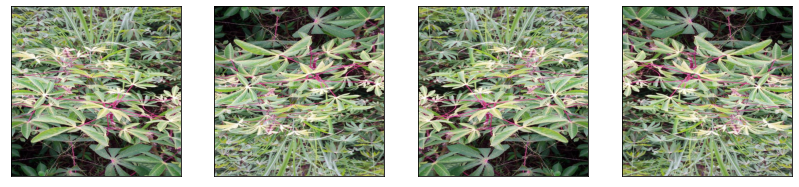

In [13]:
###### EXAMINE SAMPLE BATCH

if len(df) == 1 or CFG.debug:

    # dataset
    test_dataset = LeafData(data      = df, 
                            directory = CFG.data_path + 'test_images/' if not CFG.debug else CFG.data_path + 'train_images/',
                            transform = define_augs(CFGs[0]),
                            labeled   = False)

    # data loader
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size  = CFG.batch_size, 
                                              shuffle     = False, 
                                              num_workers = 0)

    # display 1st image with TTA
    for batch_idx, (inputs) in enumerate(test_loader):
        fig = plt.figure(figsize = (14, 7))
        for i in range(1):
            for tta_idx in range(CFG.num_tta):
                inputs_tta = get_tta_flips(inputs, tta_idx)
                ax         = fig.add_subplot(2, 4, tta_idx + 1, xticks = [], yticks = [])     
                plt.imshow(inputs_tta[i].numpy().transpose(1, 2, 0))
        break

    # clean up
    del inputs, batch_idx

# MODEL PREP

In [14]:
####### ATTENTION MODULES

'''
Borrowed from https://www.kaggle.com/jy2tong/efficientnet-b2-soft-attention
'''

class PAM_Module(nn.Module):
    ''' Position attention module'''
    #Ref from SAGAN
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in  = in_dim
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv   = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma      = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        '''
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X (HxW) X (HxW)
        '''
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key   = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy     = torch.bmm(proj_query, proj_key)
        attention  = torch.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        return out


class CAM_Module(nn.Module):
    ''' Channel attention module'''
    def __init__(self, in_dim):
        super(CAM_Module, self).__init__()
        self.chanel_in = in_dim
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self,x):
        '''
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X C X C
        '''
        m_batchsize, C, height, width = x.size()
        proj_query = x.view(m_batchsize, C, -1)
        proj_key   = x.view(m_batchsize, C, -1).permute(0, 2, 1)
        energy     = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy)-energy
        attention  = torch.softmax(energy_new, dim=-1)
        proj_value = x.view(m_batchsize, C, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(m_batchsize, C, height, width)
        out = self.gamma*out + x
        
        return out


class CBAM(nn.Module):
    def __init__(self, in_channels):
        # def __init__(self):
        super(CBAM, self).__init__()
        inter_channels = in_channels // 4
        self.conv1_c = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(inter_channels),
                                     nn.ReLU())
        
        self.conv1_s = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(inter_channels),
                                     nn.ReLU())

        self.channel_gate = CAM_Module(inter_channels)
        self.spatial_gate = PAM_Module(inter_channels)

        self.conv2_c = nn.Sequential(nn.Conv2d(inter_channels, in_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(in_channels),
                                     nn.ReLU())
        self.conv2_a = nn.Sequential(nn.Conv2d(inter_channels, in_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(in_channels),
                                     nn.ReLU())

    def forward(self, x):
        feat1    = self.conv1_c(x)
        chnl_att = self.channel_gate(feat1)
        chnl_att = self.conv2_c(chnl_att)

        feat2    = self.conv1_s(x)
        spat_att = self.spatial_gate(feat2)
        spat_att = self.conv2_a(spat_att)

        x_out = chnl_att + spat_att

        return x_out

All models were imported from the great `timm` library. I have used [this dataset](https://www.kaggle.com/kozodoi/timm-pytorch-image-models) with the most recent version of `timm`.

In [15]:
####### MODEL ARCHITECTURE

def init_model(CFG):

    ##### CONVOLUTIONAL PART

    model = timm.create_model(model_name = CFG['backbone'], pretrained = False)
    
        
    ##### CLASSIFIER PART
    
    if 'efficient' in CFG['backbone']:
        model.classifier = nn.Linear(model.classifier.in_features, CFG['num_classes'])
    elif ('vit' in CFG['backbone']) or ('deit' in CFG['backbone']):
        model.head = nn.Linear(model.head.in_features, CFG['num_classes'])
    else:
        model.fc = nn.Linear(model.fc.in_features, CFG['num_classes'])
            
            
    ##### MODEL WITH ATTENTION [EFFICIENTNET ONLY]
    
    if CFG['attention']:
        
        class model_with_attention(nn.Module):
            
            def __init__(self, CFG):
                super().__init__()
                self.backbone            = timm.create_model(model_name = CFG['backbone'], pretrained = False)
                self.backbone._dropout   = nn.Dropout(0.1)
                n_features               = self.backbone.classifier.in_features
                self.backbone.classifier = nn.Linear(n_features, CFG['num_classes'])
                self.local_fe            = CBAM(n_features)
                self.dropout             = nn.Dropout(0.1)
                self.classifier          = nn.Sequential(nn.Linear(n_features + n_features, n_features),
                                                        nn.BatchNorm1d(n_features),
                                                        nn.Dropout(0.1),
                                                        nn.ReLU(),
                                                        nn.Linear(n_features, CFG['num_classes']))

            def forward(self, image):
                enc_feas    = self.backbone.forward_features(image)
                global_feas = self.backbone.global_pool(enc_feas)
                global_feas = global_feas.flatten(start_dim = 1)
                global_feas = self.dropout(global_feas)
                local_feas  = self.local_fe(enc_feas)
                local_feas  = torch.sum(local_feas, dim = [2, 3])
                local_feas  = self.dropout(local_feas)
                all_feas    = torch.cat([global_feas, local_feas], dim = 1)
                outputs     = self.classifier(all_feas)
                return outputs
            
        model = model_with_attention(CFG)
    

    return model

# INFERENCE

The inference loop goes through all 33 models and stacks their predictions in a pandas dataframe.

In [16]:
########## INFERENCE

# timer
cv_start = time.time()
gc.collect()

# counter
all_counter = 0

# loop through models
for model_idx in tqdm(range(len(CFG.models))):
        
    # placeholders
    cnn_preds = np.zeros((len(df), CFG.num_classes))
    
    # data prep
    test_dataset = LeafData(data      = df, 
                            directory = CFG.data_path + 'test_images/' if not CFG.debug else CFG.data_path + 'train_images/',
                            transform = define_augs(CFGs[model_idx]),
                            labeled   = False)
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size  = CFG.batch_size, 
                                              shuffle     = False, 
                                              num_workers = CFG.num_workers,
                                              pin_memory  = True)
           
    # model prep
    model = init_model(CFGs[model_idx])
    model = model.to(device)
    model.load_state_dict(torch.load(CFG.models[model_idx] + 'weights_fold{}.pth'.format(CFG.one_fold),
                                     map_location = device))
    model.eval()

    # probs placeholder
    PROBS = []

    # loop through batches 
    with torch.no_grad():
        for batch_idx, inputs in enumerate(test_loader):

            # extract inputs 
            inputs = inputs.to(device)

            # preds placeholders
            probs = torch.zeros((inputs.shape[0], CFG.num_classes), device = device)

            # inference with TTA
            for tta_idx in range(CFG.num_tta): 
                preds  = model(get_tta_flips(inputs, tta_idx))
                probs += preds.softmax(axis = 1)

            # store predictions
            PROBS.append(probs.detach().cpu() / CFG.num_tta)

    # transform predictions
    PROBS      = torch.cat(PROBS).numpy()
    cnn_preds += PROBS

    # update counter
    all_counter += 1

    # clear memory
    del model, inputs, preds, probs, PROBS, test_dataset, test_loader
    gc.collect()
    
    # convert to DF
    cnn_preds = pd.DataFrame(cnn_preds, columns = [str(CFG.models[model_idx]) + str(c) for c in ['c0', 'c1', 'c2', 'c3', 'c4']])
    if model_idx == 0:
        all_cnn_preds = cnn_preds.copy()
    else:
        all_cnn_preds = pd.concat([all_cnn_preds, cnn_preds], axis = 1)
        
# print performance
print('Finished {} preds x {} TTA in {:.2f} minutes'.format(all_counter, CFG.num_tta, (time.time() - cv_start) / 60))
if CFG.debug:
    print('Estimated time to run on 15k images: {:.2f} hours'.format((time.time() - cv_start) / 360))
display(all_cnn_preds.head())

100%|██████████| 33/33 [01:39<00:00,  3.03s/it]

Finished 33 preds x 4 TTA in 1.67 minutes


,/kaggle/input/pytorch-v108/c0,/kaggle/input/pytorch-v108/c1,/kaggle/input/pytorch-v108/c2,/kaggle/input/pytorch-v108/c3,/kaggle/input/pytorch-v108/c4,/kaggle/input/pytorch-v89/c0,/kaggle/input/pytorch-v89/c1,/kaggle/input/pytorch-v89/c2,/kaggle/input/pytorch-v89/c3,/kaggle/input/pytorch-v89/c4,...,/kaggle/input/pytorch-v109/c0,/kaggle/input/pytorch-v109/c1,/kaggle/input/pytorch-v109/c2,/kaggle/input/pytorch-v109/c3,/kaggle/input/pytorch-v109/c4,/kaggle/input/pytorch-v129/c0,/kaggle/input/pytorch-v129/c1,/kaggle/input/pytorch-v129/c2,/kaggle/input/pytorch-v129/c3,/kaggle/input/pytorch-v129/c4
0,0.068959,0.046865,0.184323,0.049276,0.650576,0.012406,0.016513,0.29592,0.005316,0.669846,...,0.055081,0.087149,0.376554,0.073179,0.408038,0.061365,0.052113,0.334075,0.019029,0.533417


Two special models have a separate inference loop:
- for ImageNet classifier, we don't save probabilisitc predictions and only extract predicted classes
- for binary cassava classifier, we extract the probability of the 1st class

In [17]:
########## INFERENCE FOR IMAGENET MODEL

if '/kaggle/input/pytorch-basic-v0/' in CFG.special_models:
    
    # timer
    cv_start = time.time()

    # clear memory
    gc.collect()

    # placeholders
    cnn_preds = np.zeros((len(df), 1000))

    # data prep
    test_dataset = LeafData(data      = df, 
                            directory = CFG.data_path + 'test_images/' if not CFG.debug else CFG.data_path + 'train_images/',
                            transform = define_augs(special_CFGs[0]),
                            labeled   = False)
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size  = CFG.batch_size, 
                                              shuffle     = False, 
                                              num_workers = CFG.num_workers,
                                              pin_memory  = True)


    # model prep
    model = init_model(special_CFGs[0])
    model = model.to(device)
    model.load_state_dict(torch.load(CFG.special_models[0] + 'weights_fold0.pth', map_location = device))
    model.eval()

    # probs placeholder
    PROBS = []

    # loop through batches 
    with torch.no_grad():
        for batch_idx, inputs in enumerate(test_loader):

            # extract inputs 
            inputs = inputs.to(device)

            # preds placeholders
            probs = torch.zeros((inputs.shape[0], 1000), device = device)

            # inference with TTA
            for tta_idx in range(CFG.num_tta): 
                preds  = model(get_tta_flips(inputs, tta_idx))
                probs += preds.softmax(axis = 1)

            # store predictions
            PROBS.append(probs.detach().cpu() / CFG.num_tta)

    # transform predictions
    PROBS = torch.cat(PROBS).numpy()

    # clear memory
    del model, inputs, preds, probs
    del test_dataset, test_loader
    gc.collect()  

    # convert to DF
    PREDS_basic = np.argmax(PROBS, axis = 1)
    
    # print performance
    print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))
    if CFG.debug:
        print('Estimated time to run on 15k images: {:.2f} hours'.format((time.time() - cv_start) / 360))
    display(PREDS_basic[0:5])

Finished in 0.04 minutes


array([738])

In [18]:
########## INFERENCE FOR BINARY MODEL

if '/kaggle/input/pytorch-binary-v0/' in CFG.special_models:
    
    # timer
    cv_start = time.time()

    # clear memory
    gc.collect()

    # placeholders
    cnn_preds = np.zeros((len(df), 2))

    # data prep
    test_dataset = LeafData(data      = df, 
                            directory = CFG.data_path + 'test_images/' if not CFG.debug else CFG.data_path + 'train_images/',
                            transform = define_augs(special_CFGs[1]),
                            labeled   = False)
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size  = CFG.batch_size, 
                                              shuffle     = False, 
                                              num_workers = CFG.num_workers,
                                              pin_memory  = True)


    # model prep
    model = init_model(special_CFGs[1])
    model = model.to(device)
    model.load_state_dict(torch.load(CFG.special_models[1] + 'weights_fold0.pth', map_location = device))
    model.eval()

    # probs placeholder
    PROBS = []

    # loop through batches 
    with torch.no_grad():
        for batch_idx, inputs in enumerate(test_loader):

            # extract inputs 
            inputs = inputs.to(device)

            # preds placeholders
            probs = torch.zeros((inputs.shape[0], 2), device = device)

            # inference with TTA
            for tta_idx in range(CFG.num_tta): 
                preds  = model(get_tta_flips(inputs, tta_idx))
                probs += preds.softmax(axis = 1)

            # store predictions
            PROBS.append(probs.detach().cpu() / CFG.num_tta)

    # transform predictions
    PROBS = torch.cat(PROBS).numpy()

    # clear memory
    del model, inputs, preds, probs
    del test_dataset, test_loader
    gc.collect()  

    # convert to DF
    PREDS_binary = PROBS[:, 0]
    
    # print performance
    print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))
    if CFG.debug:
        print('Estimated time to run on 15k images: {:.2f} hours'.format((time.time() - cv_start) / 360))
    display(PREDS_binary[0:5])

Finished in 0.04 minutes


array([0.29909208], dtype=float32)

# STACKING

First, we load all OOF predictions from the used models and make sure train / test predictions have the same format.

In [19]:
####### PREPARE OOF PREDS

for m in CFG.models:

    tmp_train_preds = pd.read_csv(m + '/oof.csv')
    tmp_train_preds.columns = ['image_id', 'label', 'source', 'fold'] + [str(m) + str(c) for c in ['c0', 'c1', 'c2', 'c3', 'c4']]
    
    if m == CFG.models[0]:
        train_preds = tmp_train_preds        
    else:
        train_preds = train_preds.merge(tmp_train_preds[['image_id'] + [str(m) + str(c) for c in ['c0', 'c1', 'c2', 'c3', 'c4']]], how = 'left', on = 'image_id')
 
train_preds.head()

,image_id,label,source,fold,/kaggle/input/pytorch-v108/c0,/kaggle/input/pytorch-v108/c1,/kaggle/input/pytorch-v108/c2,/kaggle/input/pytorch-v108/c3,/kaggle/input/pytorch-v108/c4,/kaggle/input/pytorch-v89/c0,...,/kaggle/input/pytorch-v109/c0,/kaggle/input/pytorch-v109/c1,/kaggle/input/pytorch-v109/c2,/kaggle/input/pytorch-v109/c3,/kaggle/input/pytorch-v109/c4,/kaggle/input/pytorch-v129/c0,/kaggle/input/pytorch-v129/c1,/kaggle/input/pytorch-v129/c2,/kaggle/input/pytorch-v129/c3,/kaggle/input/pytorch-v129/c4
0,1000015157.jpg,0,2020,0,0.229969,0.176291,0.314087,0.041293,0.238360,0.178099,...,0.223607,0.281038,0.265011,0.069122,0.161222,0.151747,0.346524,0.285583,0.052056,0.164090
1,1000812911.jpg,3,2020,0,0.036607,0.036399,0.031094,0.854305,0.041595,0.000175,...,0.039070,0.039761,0.046947,0.833094,0.041129,0.021529,0.022048,0.023406,0.912747,0.020270
2,1003888281.jpg,0,2020,0,0.069333,0.034407,0.051365,0.038024,0.806871,0.038474,...,0.154283,0.105231,0.037109,0.022826,0.680551,0.010410,0.004690,0.006247,0.004824,0.973829
3,1004163647.jpg,3,2020,0,0.037586,0.041678,0.039882,0.828105,0.052749,0.000346,...,0.036283,0.037792,0.045315,0.844317,0.036292,0.015511,0.020124,0.021094,0.915258,0.028012
4,100472565.jpg,2,2020,0,0.042368,0.037264,0.832690,0.055563,0.032116,0.000148,...,0.049113,0.031417,0.847329,0.041621,0.030520,0.023950,0.019180,0.909500,0.032874,0.014497


In [20]:
####### PREPARE TEST PREDS

test_preds = all_cnn_preds.copy()
test_preds = pd.concat([df['image_id'], test_preds], axis = 1)
test_preds.head()

,image_id,/kaggle/input/pytorch-v108/c0,/kaggle/input/pytorch-v108/c1,/kaggle/input/pytorch-v108/c2,/kaggle/input/pytorch-v108/c3,/kaggle/input/pytorch-v108/c4,/kaggle/input/pytorch-v89/c0,/kaggle/input/pytorch-v89/c1,/kaggle/input/pytorch-v89/c2,/kaggle/input/pytorch-v89/c3,...,/kaggle/input/pytorch-v109/c0,/kaggle/input/pytorch-v109/c1,/kaggle/input/pytorch-v109/c2,/kaggle/input/pytorch-v109/c3,/kaggle/input/pytorch-v109/c4,/kaggle/input/pytorch-v129/c0,/kaggle/input/pytorch-v129/c1,/kaggle/input/pytorch-v129/c2,/kaggle/input/pytorch-v129/c3,/kaggle/input/pytorch-v129/c4
0,2216849948.jpg,0.068959,0.046865,0.184323,0.049276,0.650576,0.012406,0.016513,0.29592,0.005316,...,0.055081,0.087149,0.376554,0.073179,0.408038,0.061365,0.052113,0.334075,0.019029,0.533417


We add a couple of meta-features based on the model predictions:
- most common predicted class across the 33 models
- from our experiments, working with class predictions worked better than probabilistic predictions. Here, we compute top-4 predicted classes per each model
- finally, we add predictions from the two special models

In [21]:
####### ADD FEATURES

# most common predcted class
for m in CFG.models:
    train_preds[m] = np.argmax(train_preds.filter(like = m).values, axis = 1)
    test_preds[m]  = np.argmax(test_preds.filter(like  = m).values, axis = 1)
train_preds['mode_pred'] = train_preds[CFG.models].mode(axis = 1)[0].astype('int')
test_preds['mode_pred']  = test_preds[CFG.models].mode(axis  = 1)[0].astype('int')
for m in CFG.models:
    del train_preds[m], test_preds[m]
    
# top-4 class predictions
for m in CFG.models:

    columns = train_preds.filter(like = m).columns

    # predicted class
    train_preds[m + '1'] = np.argsort(train_preds[columns].values, axis = 1)[:,-1]
    test_preds[m  + '1'] = np.argsort(test_preds[columns].values,  axis = 1)[:,-1]

    # second-best predicted class
    train_preds[m + '2'] = np.argsort(train_preds[columns].values, axis = 1)[:,-2]
    test_preds[m  + '2'] = np.argsort(test_preds[columns].values,  axis = 1)[:,-2]

    # third-best predicted class
    train_preds[m + '3'] = np.argsort(train_preds[columns].values, axis = 1)[:,-3]
    test_preds[m  + '3'] = np.argsort(test_preds[columns].values,  axis = 1)[:,-3]
    
    # forth-best predicted class
    train_preds[m + '4'] = np.argsort(train_preds[columns].values, axis = 1)[:,-4]
    test_preds[m  + '4'] = np.argsort(test_preds[columns].values,  axis = 1)[:,-4]

    to_drop = [str(m) + str(c) for c in ['c0', 'c1', 'c2', 'c3', 'c4']]
    for col in to_drop:
        del train_preds[col]
        del test_preds[col]

In [22]:
####### ADD IMAGENET MODEL

if '/kaggle/input/pytorch-basic-v0/' in CFG.special_models:
    
    tmp_train_preds = pd.read_csv(CFG.special_models[0] + '/oof.csv')
    tmp_train_preds[CFG.special_models[0]] = tmp_train_preds['pred']
    
    train_preds = train_preds.merge(tmp_train_preds[['image_id', CFG.special_models[0]]], how = 'left', on = 'image_id')
                                                    
    test_preds[CFG.special_models[0]] = PREDS_basic
    
    display(train_preds.head(1))
    display(test_preds.head(1))

,image_id,label,source,fold,mode_pred,/kaggle/input/pytorch-v108/1,/kaggle/input/pytorch-v108/2,/kaggle/input/pytorch-v108/3,/kaggle/input/pytorch-v108/4,/kaggle/input/pytorch-v89/1,...,/kaggle/input/pytorch-v130/4,/kaggle/input/pytorch-v109/1,/kaggle/input/pytorch-v109/2,/kaggle/input/pytorch-v109/3,/kaggle/input/pytorch-v109/4,/kaggle/input/pytorch-v129/1,/kaggle/input/pytorch-v129/2,/kaggle/input/pytorch-v129/3,/kaggle/input/pytorch-v129/4,/kaggle/input/pytorch-basic-v0/
0,1000015157.jpg,0,2020,0,1,2,4,0,1,1,...,4,1,2,0,4,1,2,4,0,738


,image_id,mode_pred,/kaggle/input/pytorch-v108/1,/kaggle/input/pytorch-v108/2,/kaggle/input/pytorch-v108/3,/kaggle/input/pytorch-v108/4,/kaggle/input/pytorch-v89/1,/kaggle/input/pytorch-v89/2,/kaggle/input/pytorch-v89/3,/kaggle/input/pytorch-v89/4,...,/kaggle/input/pytorch-v130/4,/kaggle/input/pytorch-v109/1,/kaggle/input/pytorch-v109/2,/kaggle/input/pytorch-v109/3,/kaggle/input/pytorch-v109/4,/kaggle/input/pytorch-v129/1,/kaggle/input/pytorch-v129/2,/kaggle/input/pytorch-v129/3,/kaggle/input/pytorch-v129/4,/kaggle/input/pytorch-basic-v0/
0,2216849948.jpg,4,4,2,0,3,4,2,1,0,...,0,4,2,1,3,4,2,0,1,738


In [23]:
####### ADD BINARY MODEL

if '/kaggle/input/pytorch-binary-v0/' in CFG.special_models:
    
    tmp_train_preds = pd.read_csv(CFG.special_models[1] + '/oof.csv')
    tmp_train_preds[CFG.special_models[1]] = tmp_train_preds['c0']
    
    train_preds = train_preds.merge(tmp_train_preds[['image_id', CFG.special_models[1]]], how = 'left', on = 'image_id')
                                                    
    test_preds[CFG.special_models[1]] = PREDS_basic
    
    display(train_preds.head(1))
    display(test_preds.head(1))

,image_id,label,source,fold,mode_pred,/kaggle/input/pytorch-v108/1,/kaggle/input/pytorch-v108/2,/kaggle/input/pytorch-v108/3,/kaggle/input/pytorch-v108/4,/kaggle/input/pytorch-v89/1,...,/kaggle/input/pytorch-v109/1,/kaggle/input/pytorch-v109/2,/kaggle/input/pytorch-v109/3,/kaggle/input/pytorch-v109/4,/kaggle/input/pytorch-v129/1,/kaggle/input/pytorch-v129/2,/kaggle/input/pytorch-v129/3,/kaggle/input/pytorch-v129/4,/kaggle/input/pytorch-basic-v0/,/kaggle/input/pytorch-binary-v0/
0,1000015157.jpg,0,2020,0,1,2,4,0,1,1,...,1,2,0,4,1,2,4,0,738,0.666367


,image_id,mode_pred,/kaggle/input/pytorch-v108/1,/kaggle/input/pytorch-v108/2,/kaggle/input/pytorch-v108/3,/kaggle/input/pytorch-v108/4,/kaggle/input/pytorch-v89/1,/kaggle/input/pytorch-v89/2,/kaggle/input/pytorch-v89/3,/kaggle/input/pytorch-v89/4,...,/kaggle/input/pytorch-v109/1,/kaggle/input/pytorch-v109/2,/kaggle/input/pytorch-v109/3,/kaggle/input/pytorch-v109/4,/kaggle/input/pytorch-v129/1,/kaggle/input/pytorch-v129/2,/kaggle/input/pytorch-v129/3,/kaggle/input/pytorch-v129/4,/kaggle/input/pytorch-basic-v0/,/kaggle/input/pytorch-binary-v0/
0,2216849948.jpg,4,4,2,0,3,4,2,1,0,...,4,2,1,3,4,2,0,1,738,738


In [24]:
####### TRANSFORM DATA

y      = train_preds['label']
X      = train_preds.copy()
X_test = test_preds.copy()
print(X.shape, y.shape, X_test.shape)

(21397, 139) (21397,) (1, 136)


In [25]:
####### SELECT RELEVANT FEATURES

drop_features = ['image_id', 'label', 'source', 'fold']
features      = [f for f in X.columns if f not in drop_features]
print(len(features), 'features')
print(features)

135 features
['mode_pred', '/kaggle/input/pytorch-v108/1', '/kaggle/input/pytorch-v108/2', '/kaggle/input/pytorch-v108/3', '/kaggle/input/pytorch-v108/4', '/kaggle/input/pytorch-v89/1', '/kaggle/input/pytorch-v89/2', '/kaggle/input/pytorch-v89/3', '/kaggle/input/pytorch-v89/4', '/kaggle/input/pytorch-v87/1', '/kaggle/input/pytorch-v87/2', '/kaggle/input/pytorch-v87/3', '/kaggle/input/pytorch-v87/4', '/kaggle/input/pytorch-v107/1', '/kaggle/input/pytorch-v107/2', '/kaggle/input/pytorch-v107/3', '/kaggle/input/pytorch-v107/4', '/kaggle/input/pytorch-v115/1', '/kaggle/input/pytorch-v115/2', '/kaggle/input/pytorch-v115/3', '/kaggle/input/pytorch-v115/4', '/kaggle/input/pytorch-v138/1', '/kaggle/input/pytorch-v138/2', '/kaggle/input/pytorch-v138/3', '/kaggle/input/pytorch-v138/4', '/kaggle/input/pytorch-v136/1', '/kaggle/input/pytorch-v136/2', '/kaggle/input/pytorch-v136/3', '/kaggle/input/pytorch-v136/4', '/kaggle/input/pytorch-v117/1', '/kaggle/input/pytorch-v117/2', '/kaggle/input/pytorc

Stacking is performed with LightGBM on 5-fold stratfied CV over the OOFs.

In [26]:
####### STACKING LOOP

# partitinonig
skf = StratifiedKFold(n_splits = CFG.lgb_folds, random_state = CFG.seed, shuffle = True)

# placeholders
oof_preds   = np.zeros((len(X), CFG.num_classes))
importances = pd.DataFrame()

# cross-validation
print('-' * 30)    
for fold, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    
    # placeholders
    lgb_preds = np.zeros((len(X_test), CFG.num_classes))
     
    # extract samples
    X_train, y_train = X.iloc[trn_idx][features], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx][features], y.iloc[val_idx]
    X_test           = X_test[features]
    
    # modeling
    clf = lgb.LGBMClassifier(**CFG.lgb_params) 
    clf = clf.fit(X_train, y_train, 
                  eval_set              = [(X_valid, y_valid)],
                  early_stopping_rounds = CFG.lgb_stop_rounds,
                  verbose               = False)
    
    # prediction
    oof_preds[val_idx, :] = clf.predict_proba(X_valid)
    lgb_preds             = clf.predict_proba(X_test)
    
    # save preditions
    lgb_preds = pd.DataFrame(lgb_preds, columns = ['f' + str(fold) + '_' + str(c) for c in ['c0', 'c1', 'c2', 'c3', 'c4']])
    if fold == 0:
        all_lgb_preds = lgb_preds.copy()
    else:
        all_lgb_preds = pd.concat([all_lgb_preds, lgb_preds], axis = 1)
        
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature']    = features
    fold_importance_df['Importance'] = clf.feature_importances_
    fold_importance_df['Fold']       = fold + 1
    importances = pd.concat([importances, fold_importance_df], axis = 0)

    # information
    print('- FOLD {}: accuracy = {:.4f}'.format(fold + 1, (np.argmax(oof_preds[val_idx, :], axis = 1) == y_valid).sum() / len(y_valid)))
    
# print performance
print('-' * 30)
print('OOF accuracy = {:.4f}'.format((np.argmax(oof_preds, axis = 1) == y).sum() / len(y)))
print('-' * 30)

------------------------------
- FOLD 1: accuracy = 0.9044
- FOLD 2: accuracy = 0.9044
- FOLD 3: accuracy = 0.9037
- FOLD 4: accuracy = 0.9077
- FOLD 5: accuracy = 0.9131
------------------------------
OOF accuracy = 0.9067
------------------------------


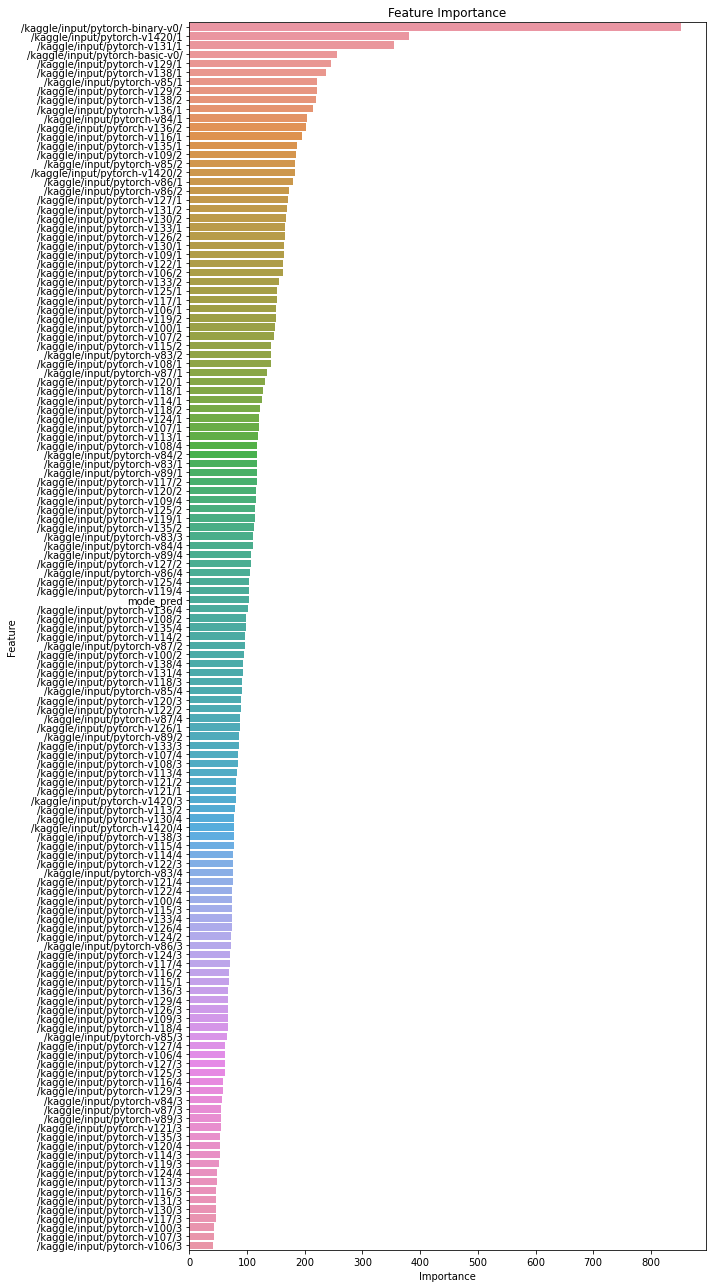

In [27]:
###### FEATURE IMPORTANCE

fig  = plt.figure(figsize = (10, 18))
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False).index
importance = importances.loc[importances.Feature.isin(cols)].groupby('Feature').mean().reset_index(drop = False)
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False), ci = 0)
plt.title('Feature Importance')
plt.tight_layout()

Looking at feature importance, you can notice that two special models are ranked fairly high.

In [28]:
####### BLEND STACKING FOLD PREDCITIONS

for c in ['c0', 'c1', 'c2', 'c3', 'c4']:
    all_lgb_preds[c] = all_lgb_preds.filter(like = c).mean(axis = 1)

display(all_lgb_preds[['c0', 'c1', 'c2', 'c3', 'c4']].head(1))

,c0,c1,c2,c3,c4
0,0.022745,0.051877,0.272498,0.167139,0.485741


# SUBMISSION

In [29]:
####### TIMER

if CFG.debug:
    print('Estimated time to run inference on 15k images: {:.2f} hours'.format((time.time() - notebook_start) / 360))

In [30]:
####### SUBMISSION FILE

if all_counter == len(CFG.models): 
    
    df['label'] = np.argmax(all_lgb_preds[['c0', 'c1', 'c2', 'c3', 'c4']].values, axis = 1)
                                
    if not CFG.debug: 
        df.to_csv('submission.csv', index = False)
    
    if len(df) == 1:
        display(df)

,image_id,label
0,2216849948.jpg,4
